In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pykeen.datasets.hetionet import Hetionet
from scipy import stats
import sys
import os
from pykeen.datasets.base import PathDataset
from pykeen.predict import predict_target
from scipy.stats import kstest
import pickle
from scipy.stats import mannwhitneyu

sys.path.append(os.path.abspath('../src/'))

from utils import get_predictions_tail

/Users/michael/miniconda3/envs/link/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
TEST_PATH: str =  '../ELs_for_Rotate/String_HPO_2019.all_hpo/test.txt'
TRAIN_PATH: str = '../ELs_for_Rotate/String_HPO_2019.all_hpo/train.txt'
VALID_PATH: str = '../ELs_for_Rotate/String_HPO_2019.all_hpo/valid.txt'

class STRINGHPO(PathDataset):
    def __init__(self, **kwargs):
        super().__init__(
            training_path=TRAIN_PATH,
            testing_path=TEST_PATH,
            validation_path=VALID_PATH,
            **kwargs,
        )

data = STRINGHPO()
data.summarize() 

# these are used to know if a triple is in the training, testing or validation set
train_triples = set([ str(x) for x in data.training.triples])
test_triples = set([ str(x) for x in data.testing.triples])
valid_triples = set([ str(x) for x in data.validation.triples])

You're trying to map triples with 537 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 535 from 30992 triples were filtered out
Reconstructing all label-based triples. This is expensive and rarely needed.


STRINGHPO (create_inverse_triples=False)
Name        Entities    Relations      Triples
----------  ----------  -----------  ---------
Training    36245       3              6029790
Testing     36245       3                30457
Validation  36245       3               135927
Total       -           -              6196174
Head        Relation    tail
----------  ----------  ----------
HP:0000001  HPO2HPO     HP:0000005
HP:0000001  HPO2HPO     HP:0000118
HP:0000001  HPO2HPO     HP:0012823
HP:0000001  HPO2HPO     HP:0031797
HP:0000001  HPO2HPO     HP:0032223



Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


In [3]:
# Load the STRING_HPO network edges
df: pd.DataFrame = pd.read_csv(
    "../ELs_for_Rotate/String_HPO_2019.all_hpo/train.txt", sep="\t"
)
df.columns = ["source", "relation", "target"]

# Load these edges into a NX graph and compute the degree for each entity
G: nx.MultiGraph = nx.from_pandas_edgelist(
    df, "source", "target", create_using=nx.MultiGraph()
)
degs: dict = dict(G.degree())

## Load Model

In [4]:
# Load the pretrained model
model = torch.load(
    "../PyKeenOut/stringhpo_rotate_trail_1.2/trained_model.pkl",
    map_location=torch.device("cpu"),
)

## Sex Specific Rankings
What is the relationship between rank for a gene to be connected to a specific HPO term for only gene-phenotype pairs that are not connected at time t but are in t+1?

### For HPO terms that I manually curated as being sex specific

In [5]:
# get a set of genes
genes = set()
for line in open(TRAIN_PATH,'r'):
    row = line.strip().split('\t')
    if 'STRING:' in row[0]:
        genes.add(row[0])
    if 'STRING:' in row[2]:
        genes.add(row[2])
genes = list(genes)
# sort the genes
genes.sort()
print('# genes', len(genes))

female_terms = []
male_terms = []
for line in open('../SexCurationResults/file_1686685843.3780549.csv','r'):
    row = line.strip().split(',')
    if row[2] == 'm':
        male_terms.append(row[1])
    elif row[2] == 'f':
        female_terms.append(row[1])
    elif row[2] == 'o':
        pass
    else: 
        print('error', row)

print('Number of female terms:',len(female_terms))
print('Number of male terms:',len(male_terms))
print(genes[:10])


# genes 21659
error ['', 'hpo', 'label']
error ['0', 'hpo', 'label']
Number of female terms: 288
Number of male terms: 192
['STRING:1', 'STRING:1-minute', 'STRING:1st', 'STRING:2', 'STRING:2nd', 'STRING:3rd', 'STRING:4th', 'STRING:5', 'STRING:5-oxoprolinase', 'STRING:5th']


In [17]:
# check if 'all_female_hpo_percentiles.pkl' exists
# if it does not exist -- good luck this will take a while
if not os.path.isfile('female_hpo2genes_percentiles.pkl') and not os.path.isfile('male_hpo2genes_percentiles.pkl'):
    female_hpo2genes_percentiles = {}
    for i,term in enumerate(female_terms):
        if i % 20 == 0:
            print(round(i/len(female_terms),2) * 100, '% done')
        try:
            predictions_df: pd.DataFrame = get_predictions_tail(
                term,
                'STRING2HPO',
                data,
                model,
                degs,
                train_triples=train_triples,
                test_triples=test_triples,
                valid_triples=valid_triples
            )
        except KeyError:
            print('key error', term)
            continue
        # remove 'HP:' terms from the predictions
        predictions_df = predictions_df[~predictions_df['tail_label'].str.contains('HP:')]
        predictions_df['percentile'] = predictions_df['score'].rank(pct=True)
        # sort the predictions by the tail_label
        predictions_df = predictions_df.sort_values(by=['tail_label'])
        female_hpo2genes_percentiles[term] = predictions_df['percentile'].tolist()
    male_hpo2genes_percentiles = {}
    for i,term in enumerate(male_terms):
        if i % 20 == 0:
            print(round(i/len(male_terms),2) * 100, '% done')
        try:
            predictions_df: pd.DataFrame = get_predictions_tail(
                term,
                'STRING2HPO',
                data,
                model,
                degs,
                train_triples=train_triples,
                test_triples=test_triples,
                valid_triples=valid_triples
            )
        except KeyError:
            print('key error', term)
            continue
        # remove 'HP:' terms from the predictions
        predictions_df = predictions_df[~predictions_df['tail_label'].str.contains('HP:')]
        predictions_df['percentile'] = predictions_df['score'].rank(pct=True)
        # sort the predictions by the tail_label
        predictions_df = predictions_df.sort_values(by=['tail_label'])
        male_hpo2genes_percentiles[term] = predictions_df['percentile'].tolist()
    pickle.dump(female_hpo2genes_percentiles,open('female_hpo2genes_percentiles.pkl','wb'))
    pickle.dump(male_hpo2genes_percentiles,open('male_hpo2genes_percentiles.pkl','wb'))
    
    


0.0 % done
key error HP:0034558
key error HP:0034344
key error HP:0034268
key error HP:0034263
key error HP:0034264
key error HP:0034266
key error HP:0034269
7.000000000000001 % done
14.000000000000002 % done
key error HP:0033084
key error HP:0033085
key error HP:0033086
key error HP:0033840
key error HP:0033338
key error HP:0034719
21.0 % done
key error HP:0034503
key error HP:0034571
28.000000000000004 % done
key error HP:0034709
35.0 % done
key error HP:0034326
42.0 % done
key error HP:4000153
key error HP:0033020
49.0 % done
key error HP:0033588
56.00000000000001 % done
62.0 % done
key error HP:0034492
key error HP:0034546
69.0 % done
key error HP:0025715
key error HP:0025719
76.0 % done
key error HP:0025664
key error HP:0025665
key error HP:0025666
key error HP:0033712
key error HP:0025675
83.0 % done
key error HP:0032571
90.0 % done
key error HP:0034756
key error HP:0034757
key error HP:0034758
key error HP:0034778
key error HP:4000173
key error HP:0033587
key error HP:0033758
97

In [7]:
# pickle load
female_hpo2genes_percentiles = pickle.load(open('female_hpo2genes_percentiles.pkl','rb'))
male_hpo2genes_percentiles = pickle.load(open('male_hpo2genes_percentiles.pkl','rb'))

In [18]:
print('Number of female specific terms:',len(female_hpo2genes_percentiles))
print('Number of male specific terms:',len(male_hpo2genes_percentiles))

# example of structure of these dictionaries
print(list(female_hpo2genes_percentiles.keys())[0])
print(female_hpo2genes_percentiles['HP:0030161'])
print('Number of measurements:',len(female_hpo2genes_percentiles['HP:0030161']))


Number of female specific terms: 251
Number of male specific terms: 169
HP:0030161
[0.1105775889930283, 0.0012927651322775752, 0.08366037213167736, 0.06163719469966296, 0.07202548594117919, 0.001154254582390692, 0.06542314972990443, 0.16967542361143173, 0.009603398125490558, 0.0633916616648968, 0.020868922849623713, 0.011404035274020037, 0.04030657001708297, 0.3013527863705619, 0.4826169259891962, 0.03559721132092895, 0.45565353894454963, 0.46710374440186525, 0.38358188282007477, 0.249503670529572, 0.26774089293134495, 0.17743201440509718, 0.3779952906413038, 0.39835634147467563, 0.20504178401588255, 0.17803222678794034, 0.17849392862089664, 0.20157902026871047, 0.39854102220785814, 0.17576988780645458, 0.40795973960016624, 0.6927836003508934, 0.2653400433999723, 0.4977607461101621, 0.5836834572233252, 0.4306292995983194, 0.1624728750173138, 0.7515120735029318, 0.7438478230758576, 0.2456715453160349, 0.5516875201994552, 0.48016990627452794, 0.35481785862689874, 0.5923172814996076, 0.44

### Get the list of genes connect to these HPO terms in t+1 but not in t
The training, validation and test sets used for the model were 2019,2020 and 2021 respectively. So we will consider t=2021 for this experiment to be super sure the t+1 edges have never been seen of measured again by the model.

In [19]:
def split_sort_return_str(line):
    # split a line on tabs, sort the elements and return a string
    return '\t'.join(sorted(line.split('\t')))

# get the t edge list, this was the validation set for 2019
t_el = '../ELs_for_Rotate/String_HPO_2019.all_hpo/test.txt'
# load t_el as a set of string
t_el_set = set([split_sort_return_str(line) for line in open(t_el,'r')])
# ge the t+1 edge list, this was the validation set for 2020
tp1_el = '../ELs_for_Rotate/String_HPO_2020.all_hpo/test.txt'
# load tp1_el as a set of string
tp1_el_set = set([split_sort_return_str(line) for line in open(tp1_el,'r')])

new_edges_tp1 = tp1_el_set.difference(t_el_set)
print('Number of new edges in 2022', len(new_edges_tp1))
# get just the genes that are related to sex specific phenotypes
female_specific_phenotypes2genes = {}
for term in female_hpo2genes_percentiles.keys():
    female_specific_phenotypes2genes[term] = []
    tmp_seen_genes = set()
    for edge_line in new_edges_tp1:
        # if the term is in the edge and the edge is g2p
        if term in edge_line and 'STRING:' in edge_line and 'HP:' in edge_line:
            edge = edge_line.strip().split('\t')
            # get the gene
            gene = [x for x in edge if 'STRING:' in x][0]
            if gene in tmp_seen_genes:
                continue
            tmp_seen_genes.add(gene)
            if gene not in genes:
                print('gene not in genes', gene)
                continue
            gi = genes.index(gene)
            female_specific_phenotypes2genes[term].append(female_hpo2genes_percentiles[term][gi])
# do the same for males now
male_specific_phenotypes2genes = {}
for term in male_hpo2genes_percentiles.keys():
    male_specific_phenotypes2genes[term] = []
    tmp_seen_genes = set()
    for edge_line in new_edges_tp1:
        # if the term is in the edge and the edge is g2p
        if term in edge_line and 'STRING:' in edge_line and 'HP:' in edge_line:
            edge = edge_line.strip().split('\t')
            # get the gene
            gene = [x for x in edge if 'STRING:' in x][0]
            if gene in tmp_seen_genes:
                continue
            tmp_seen_genes.add(gene)
            if gene not in genes:
                print('gene not in genes', gene)
                continue
            gi = genes.index(gene)
            male_specific_phenotypes2genes[term].append(male_hpo2genes_percentiles[term][gi])

Number of new edges in 2022 18666
gene not in genes STRING:VARS1
gene not in genes STRING:SVBP
gene not in genes STRING:CCDC32
gene not in genes STRING:PALS1
gene not in genes STRING:H1-4


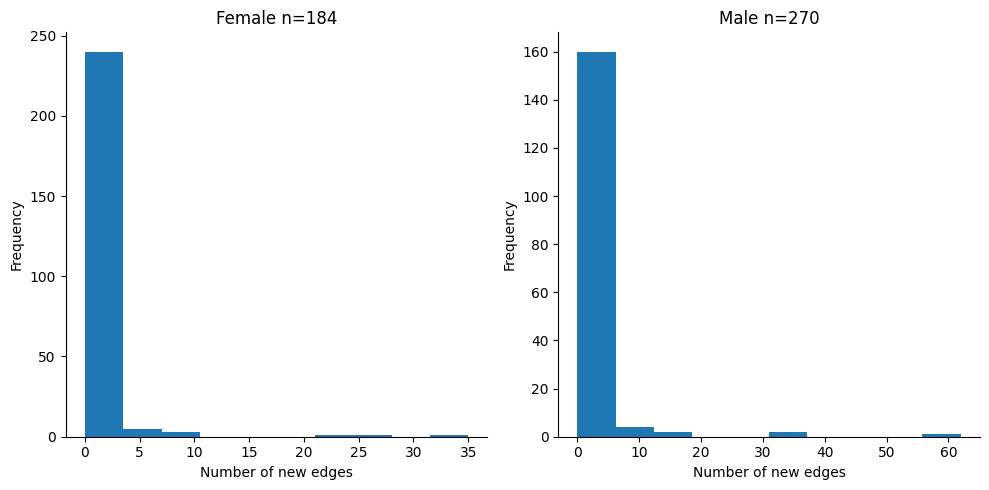

In [20]:
flattened_percentiles = {'female':[],'male':[]}

for key in female_specific_phenotypes2genes.keys():
    flattened_percentiles['female'] += list(female_specific_phenotypes2genes[key])

for key in male_specific_phenotypes2genes.keys():
    flattened_percentiles['male'] += list(male_specific_phenotypes2genes[key])

# hist of the number of genes per term divided by male and female
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].hist([ len(female_specific_phenotypes2genes[key]) for key in female_specific_phenotypes2genes.keys()])
axes[0].set_title('Female n={}'.format(str(len(flattened_percentiles['female']))))
# remove top and right borders
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xlabel('Number of new edges')
axes[0].set_ylabel('Frequency')
# male
axes[1].hist([ len(male_specific_phenotypes2genes[key]) for key in male_specific_phenotypes2genes.keys()])
axes[1].set_title('Male n={}'.format(str(len(flattened_percentiles['male']))))
axes[1].set_xlabel('Number of new edges')
axes[1].set_ylabel('Frequency')

# remove top and right borders
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

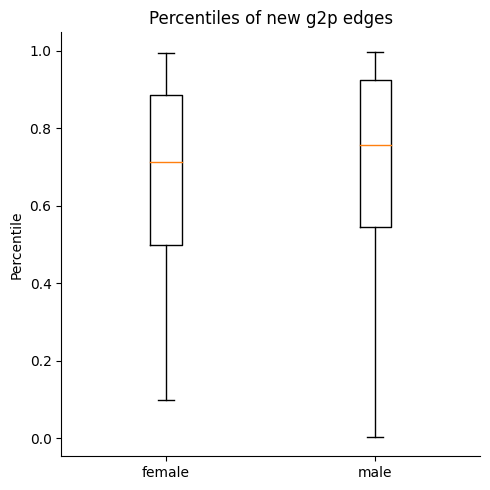

[0.09894270280253012, 0.10619142157994367, 0.13080012927651322, 0.13315480862459023, 0.1451128860981578, 0.14534373701463596, 0.156747772288656, 0.15919479200332426, 0.1607645782353756, 0.19035966572787294, 0.2025947643012143, 0.20970497252874093, 0.22327900641765547, 0.24774920356433816, 0.25158132877787526, 0.25513643289163856, 0.2820074795696939, 0.29096449512904565, 0.297243640057251, 0.3025532111362482, 0.30296874278590885, 0.3250380904012189, 0.3380580820905859, 0.3420748880373055, 0.36262061960385983, 0.3630823214368161, 0.3897686873816889, 0.4134078212290503, 0.4175169675423611, 0.41982547670714254, 0.4290595133662681, 0.434276744078674, 0.45232928574726444, 0.4566231127937578, 0.46387183157117134, 0.4651184265201533, 0.466642042568909, 0.4707973590655155, 0.47707650399372087, 0.4777690567431553, 0.49171245209843484, 0.49226649429798236, 0.4933284085137818, 0.49660649152777137, 0.4976222355602752, 0.4988688305092571, 0.4988688305092571, 0.49997691490835217, 0.5089801006509996, 

In [37]:
# box plots of the percentiles for each term
fig, ax = plt.subplots( figsize=(5, 5))

ax.boxplot(flattened_percentiles.values())
ax.set_xticklabels(flattened_percentiles.keys())

ax.set_title('Percentiles of new g2p edges')
ax.set_ylabel('Percentile')
# remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../Figures/female_v_male_g2p_rankings_boxplot.png')
plt.show()
flattened_percentiles['female'].sort()
flattened_percentiles['male'].sort()
print(flattened_percentiles['female'])
print(flattened_percentiles['male'])
print(len(flattened_percentiles['female']))
print(len(flattened_percentiles['male']))
U1, p = mannwhitneyu(flattened_percentiles['female'], flattened_percentiles['male'], method="exact")

print('Percent of genes in top 10%')
print('female', len([x for x in flattened_percentiles['female'] if x > 0.8])/len(flattened_percentiles['female']))
print('male', len([x for x in flattened_percentiles['male'] if x > 0.8])/len(flattened_percentiles['male']))

print('p-value', p)

# do Mann Whitney U test for but percentils > 0.9
U1_8, p_8 = mannwhitneyu([x for x in flattened_percentiles['female'] if x >= .8], [x for x in flattened_percentiles['male'] if x >= .8], method="exact")
print('p-value for scores > 0.8', p_8)


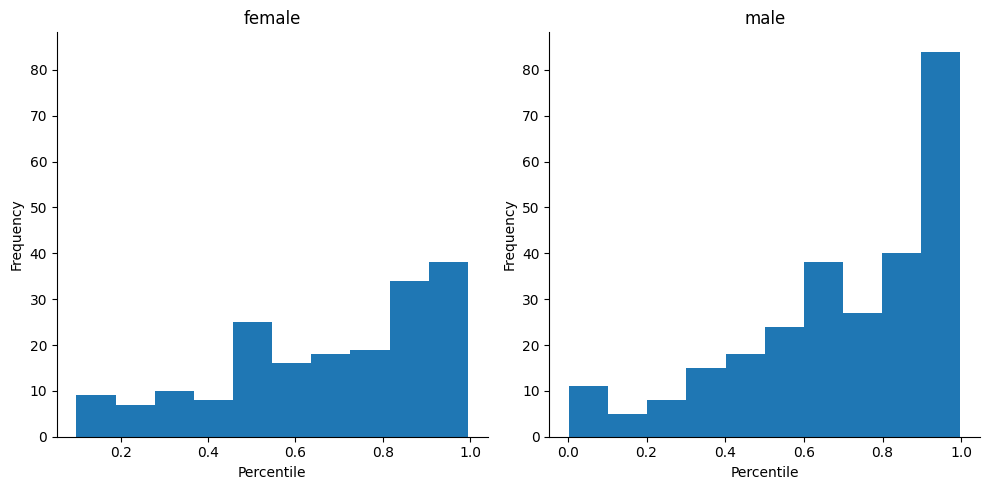

0.7122443326100004
0.756567708573803


In [22]:
# histogram of the percentiles

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].hist(flattened_percentiles['female'],bins=10)
axes[0].set_title('female')
axes[0].set_xlabel('Percentile')
axes[0].set_ylabel('Frequency')
axes[1].hist(flattened_percentiles['male'],bins=10)
axes[1].set_title('male')
axes[1].set_xlabel('Percentile')
axes[1].set_ylabel('Frequency')

# remove top and right borders
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# match the y axis range
max_y = max([max(axes[0].get_ylim()),max(axes[1].get_ylim())])
axes[0].set_ylim([0,max_y])
axes[1].set_ylim([0,max_y])


plt.tight_layout()
plt.savefig('../Figures/female_v_male_g2p_rankings_hist.png')
plt.show()

# what is the median value for each sex?
print(np.median(flattened_percentiles['female']))
print(np.median(flattened_percentiles['male']))




In [40]:
def get_percentile_dict(hpos,relation,data,model,degs,train_triples,test_triples,valid_triples):
    hpo2genes_percentiles = {}
    for i,term in enumerate(hpos):
        if i % 20 == 0:
            print(round(i/len(hpos),2) * 100, '% done')
        try:
            predictions_df: pd.DataFrame = get_predictions_tail(
                term,
                'STRING2HPO',
                data,
                model,
                degs,
                train_triples=train_triples,
                test_triples=test_triples,
                valid_triples=valid_triples
            )
        except KeyError:
            print('key error', term)
            continue
        # remove 'HP:' terms from the predictions
        predictions_df = predictions_df[~predictions_df['tail_label'].str.contains('HP:')]
        predictions_df['percentile'] = predictions_df['score'].rank(pct=True)
        # sort the predictions by the tail_label
        predictions_df = predictions_df.sort_values(by=['tail_label'])
        hpo2genes_percentiles[term] = predictions_df['percentile'].tolist()
    return hpo2genes_percentiles

def get_group_speficic_percentiles(all_genes,x_percentiles,new_edges_tp1):
    specific_phenotypes2genes = {}
    for term in x_percentiles.keys():
        specific_phenotypes2genes[term] = []
        tmp_seen_genes = set()
        for edge_line in new_edges_tp1:
            # if the term is in the edge and the edge is g2p
            if term in edge_line and 'STRING:' in edge_line and 'HP:' in edge_line:
                edge = edge_line.strip().split('\t')
                # get the gene
                gene = [x for x in edge if 'STRING:' in x][0]
                if gene in tmp_seen_genes:
                    continue
                tmp_seen_genes.add(gene)
                if gene not in all_genes:
                    print('gene not in genes', gene)
                    continue
                gi = all_genes.index(gene)
                specific_phenotypes2genes[term].append(x_percentiles[term][gi])
    return specific_phenotypes2genes

def two_group_g2p_ranking_test(prefix,hpos_a,hpos_b,label_a,label_b,data,model,degs,train_triples,test_triples,valid_triples,all_genes):
    # get the t edge list, this was the validation set for 2019
    t_el = '../ELs_for_Rotate/String_HPO_2019.all_hpo/test.txt'
    # load t_el as a set of string
    t_el_set = set([split_sort_return_str(line) for line in open(t_el,'r')])
    # ge the t+1 edge list, this was the validation set for 2020
    tp1_el = '../ELs_for_Rotate/String_HPO_2020.all_hpo/test.txt'
    # load tp1_el as a set of string
    tp1_el_set = set([split_sort_return_str(line) for line in open(tp1_el,'r')])
    new_edges_tp1 = tp1_el_set.difference(t_el_set)

    a_percentiles = get_percentile_dict(hpos_a,'STRING2HPO',data,model,degs,train_triples,test_triples,valid_triples)
    b_percentiles = get_percentile_dict(hpos_b,'STRING2HPO',data,model,degs,train_triples,test_triples,valid_triples)
    a_specific_percentiles = get_group_speficic_percentiles(all_genes,a_percentiles,new_edges_tp1)
    b_specific_percentiles = get_group_speficic_percentiles(all_genes,b_percentiles,new_edges_tp1)

    flattened_percentiles = {label_a:[],label_b:[]}

    for key in a_specific_percentiles.keys():
        flattened_percentiles[label_a] += list(a_specific_percentiles[key])

    for key in b_specific_percentiles.keys():
        flattened_percentiles[label_b] += list(b_specific_percentiles[key])

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].hist(flattened_percentiles[label_a],bins=10)
    axes[0].set_title(label_a)
    axes[0].set_xlabel('Percentile')
    axes[0].set_ylabel('Frequency')
    axes[1].hist(flattened_percentiles[label_b],bins=10)
    axes[1].set_title(label_b)
    axes[1].set_xlabel('Percentile')
    axes[1].set_ylabel('Frequency')

    # remove top and right borders
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)

    # match the y axis range
    max_y = max([max(axes[0].get_ylim()),max(axes[1].get_ylim())])
    axes[0].set_ylim([0,max_y])
    axes[1].set_ylim([0,max_y])


    plt.tight_layout()
    plt.savefig('../Figures/{}_{}_v_{}_g2p_rankings_hist.png'.format(prefix,label_a,label_b))
    plt.show()

    # Mann Whitney is a non-parametric test intended for 2 groups
    print(len(flattened_percentiles[label_a]))
    print(len(flattened_percentiles[label_b]))
    flattened_percentiles[label_a].sort()
    flattened_percentiles[label_b].sort()
    print(flattened_percentiles[label_a])
    print(flattened_percentiles[label_b])
    U1, p = mannwhitneyu(flattened_percentiles[label_a], flattened_percentiles[label_b], method="exact")
    print('p-value', p)

    # what percent of the genes are in the top 10%?
    print('Percent of genes in top 10%')
    print(label_a, len([x for x in flattened_percentiles[label_a] if x > 0.8])/len(flattened_percentiles[label_a]))
    print(label_b, len([x for x in flattened_percentiles[label_b] if x > 0.8])/len(flattened_percentiles[label_b]))

    U1_8, p_8 = mannwhitneyu([x for x in flattened_percentiles[label_a] if x >= .8], [x for x in flattened_percentiles[label_b] if x >= .8], method="exact")
    print('p-value for scores > 0.8', p_8)

    return p
    

0.0 % done
key error HP:0034558
key error HP:0034344
key error HP:0034268
key error HP:0034263
key error HP:0034264
key error HP:0034266
key error HP:0034269
7.000000000000001 % done
14.000000000000002 % done
key error HP:0033084
key error HP:0033085
key error HP:0033086
key error HP:0033840
key error HP:0033338
key error HP:0034719
21.0 % done
key error HP:0034503
key error HP:0034571
28.000000000000004 % done
key error HP:0034709
35.0 % done
key error HP:0034326
42.0 % done
key error HP:4000153
key error HP:0033020
49.0 % done
key error HP:0033588
56.00000000000001 % done
62.0 % done
key error HP:0034492
key error HP:0034546
69.0 % done
key error HP:0025715
key error HP:0025719
76.0 % done
key error HP:0025664
key error HP:0025665
key error HP:0025666
key error HP:0033712
key error HP:0025675
83.0 % done
key error HP:0032571
90.0 % done
key error HP:0034756
key error HP:0034757
key error HP:0034758
key error HP:0034778
key error HP:4000173
key error HP:0033587
key error HP:0033758
97

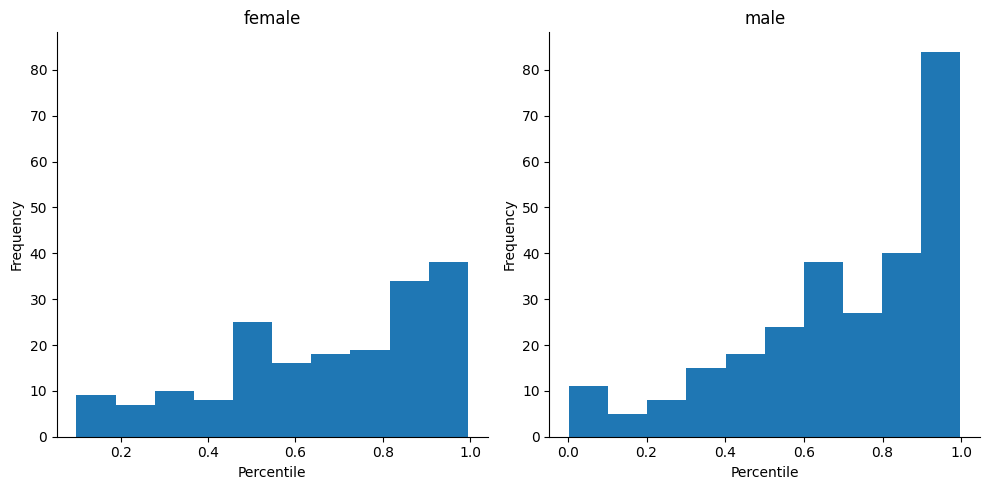

184
270
[0.09894270280253012, 0.10619142157994367, 0.13080012927651322, 0.13315480862459023, 0.1451128860981578, 0.14534373701463596, 0.156747772288656, 0.15919479200332426, 0.1607645782353756, 0.19035966572787294, 0.2025947643012143, 0.20970497252874093, 0.22327900641765547, 0.24774920356433816, 0.25158132877787526, 0.25513643289163856, 0.2820074795696939, 0.29096449512904565, 0.297243640057251, 0.3025532111362482, 0.30296874278590885, 0.3250380904012189, 0.3380580820905859, 0.3420748880373055, 0.36262061960385983, 0.3630823214368161, 0.3897686873816889, 0.4134078212290503, 0.4175169675423611, 0.41982547670714254, 0.4290595133662681, 0.434276744078674, 0.45232928574726444, 0.4566231127937578, 0.46387183157117134, 0.4651184265201533, 0.466642042568909, 0.4707973590655155, 0.47707650399372087, 0.4777690567431553, 0.49171245209843484, 0.49226649429798236, 0.4933284085137818, 0.49660649152777137, 0.4976222355602752, 0.4988688305092571, 0.4988688305092571, 0.49997691490835217, 0.5089801006

In [39]:
manual_p = two_group_g2p_ranking_test(prefix='manually_curated',
                            hpos_a=female_terms,
                            hpos_b=male_terms,
                            label_a='female',
                            label_b='male',
                            data=data,
                            model=model,
                            degs=degs,
                            train_triples=train_triples,
                            test_triples=test_triples,
                            valid_triples=valid_triples,
                            all_genes=genes)

## HPO Terms annotated as female or male
In the HPO annotation file there is a column to indicate if a relationship is sex specific. The HPO terms associated here are not necessarily inherently sex specific, but the link between them as a disease in OMIM has been labeled as such.

In [41]:
female_annotated_hpos: list = [ line.strip() for line in open('../Resources/just_female_hpos.txt')]
print('# female terms', len(female_annotated_hpos))
male_annotated_hpos: list = [ line.strip() for line in open('../Resources/just_male_hpos.txt')]
print('# female terms', len(male_annotated_hpos))

# female terms 87
# female terms 169


0.0 % done
key error HP:0033085
23.0 % done
46.0 % done
69.0 % done
92.0 % done
0.0 % done
key error HP:0033195
key error HP:0033725
12.0 % done
key error HP:0034049
24.0 % done
key error HP:0033606
36.0 % done
47.0 % done
key error HP:0033425
59.0 % done
71.0 % done
83.0 % done
95.0 % done
gene not in genes STRING:HRURF
gene not in genes STRING:MARS1
gene not in genes STRING:H1-4
gene not in genes STRING:AARS1
gene not in genes STRING:AARS1
gene not in genes STRING:MARS1
gene not in genes STRING:ADPRS
gene not in genes STRING:G6PC1
gene not in genes STRING:EPRS1
gene not in genes STRING:MARS1
gene not in genes STRING:AARS1
gene not in genes STRING:DYNLT2B
gene not in genes STRING:MARS1
gene not in genes STRING:YARS1
gene not in genes STRING:MARS1
gene not in genes STRING:NARS1
gene not in genes STRING:CCDC32
gene not in genes STRING:DYNLT2B
gene not in genes STRING:HRURF
gene not in genes STRING:H1-4
gene not in genes STRING:VARS1
gene not in genes STRING:ADPRS
gene not in genes STRIN

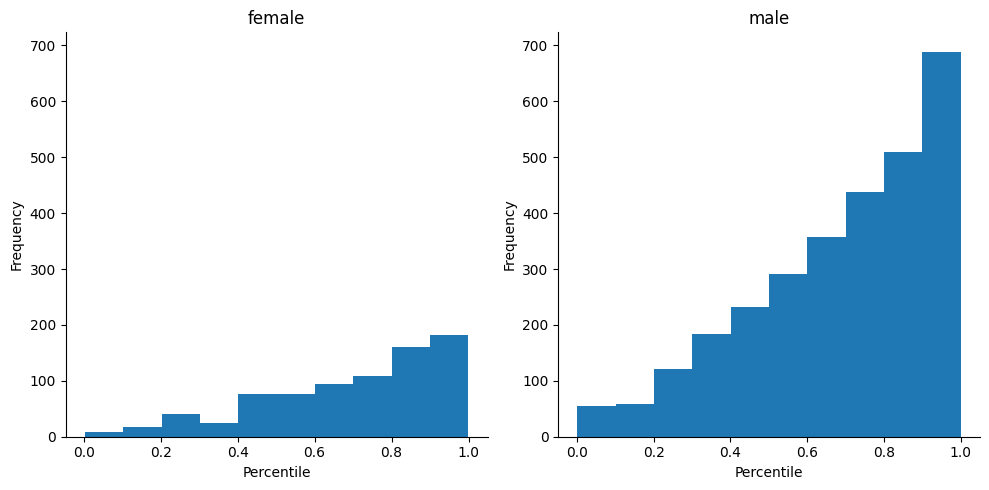

790
2936
[0.0031395724641026827, 0.04141465441617803, 0.04547763054619327, 0.04912507502654786, 0.052449328223833046, 0.07581144097142066, 0.07802760976961079, 0.0942333441063761, 0.09672653400434, 0.11099312064268896, 0.12096588023454453, 0.14132693106791633, 0.1430813980331502, 0.14534373701463596, 0.14552841774781847, 0.15536266678978716, 0.15919479200332426, 0.16118010988503625, 0.1727688258922388, 0.17747818458839282, 0.18251073456761624, 0.1829262662172769, 0.1884666882127522, 0.19326838727549747, 0.1939609400249319, 0.19973221293688537, 0.212798374809548, 0.21838496698831894, 0.2191698601043446, 0.21935454083752712, 0.21944688120411837, 0.21958539175400527, 0.22327900641765547, 0.2378226141557782, 0.24253197285193223, 0.24437878018375733, 0.2446558012835311, 0.24636409806546933, 0.25024239346230204, 0.2505194145620758, 0.25158132877787526, 0.25472090124197794, 0.25513643289163856, 0.2560136663742555, 0.256567708573803, 0.25915323883835817, 0.26007664250427076, 0.2637240869846253

: 

: 

In [42]:
manual_p = two_group_g2p_ranking_test(prefix='annotated',
                            hpos_a=female_annotated_hpos,
                            hpos_b=male_annotated_hpos,
                            label_a='female',
                            label_b='male',
                            data=data,
                            model=model,
                            degs=degs,
                            train_triples=train_triples,
                            test_triples=test_triples,
                            valid_triples=valid_triples,
                            all_genes=genes)